In [14]:
!unzip /content/tags.zip -d /content/

Archive:  /content/tags.zip
   creating: /content/tags/
  inflating: /content/__MACOSX/._tags  
  inflating: /content/tags/IMG_0.jpg  
  inflating: /content/__MACOSX/tags/._IMG_0.jpg  
  inflating: /content/tags/IMG_0301.jpg  
  inflating: /content/__MACOSX/tags/._IMG_0301.jpg  
  inflating: /content/tags/IMG_0315.jpg  
  inflating: /content/__MACOSX/tags/._IMG_0315.jpg  
  inflating: /content/tags/IMG_0329.jpg  
  inflating: /content/__MACOSX/tags/._IMG_0329.jpg  
  inflating: /content/tags/IMG_0328.jpg  
  inflating: /content/__MACOSX/tags/._IMG_0328.jpg  
  inflating: /content/tags/IMG_0314.jpg  
  inflating: /content/__MACOSX/tags/._IMG_0314.jpg  
  inflating: /content/tags/IMG_0300.jpg  
  inflating: /content/__MACOSX/tags/._IMG_0300.jpg  
  inflating: /content/tags/IMG_0316.jpg  
  inflating: /content/__MACOSX/tags/._IMG_0316.jpg  
  inflating: /content/tags/IMG_0302.jpg  
  inflating: /content/__MACOSX/tags/._IMG_0302.jpg  
  inflating: /content/tags/IMG_0303.jpg  
  inflating: 

In [16]:
!unzip -o /content/monster.zip -d /content/

Archive:  /content/monster.zip
   creating: /content/monster/
  inflating: /content/__MACOSX/._monster  
  inflating: /content/monster/IMG_0404.jpg  
  inflating: /content/__MACOSX/monster/._IMG_0404.jpg  
  inflating: /content/monster/IMG_0410.jpg  
  inflating: /content/__MACOSX/monster/._IMG_0410.jpg  
  inflating: /content/monster/IMG_0438.jpg  
  inflating: /content/__MACOSX/monster/._IMG_0438.jpg  
  inflating: /content/monster/IMG_0439.jpg  
  inflating: /content/__MACOSX/monster/._IMG_0439.jpg  
  inflating: /content/monster/IMG_0411.jpg  
  inflating: /content/__MACOSX/monster/._IMG_0411.jpg  
  inflating: /content/monster/IMG_0405.jpg  
  inflating: /content/__MACOSX/monster/._IMG_0405.jpg  
  inflating: /content/monster/IMG_0413.jpg  
  inflating: /content/__MACOSX/monster/._IMG_0413.jpg  
  inflating: /content/monster/IMG_0407.jpg  
  inflating: /content/__MACOSX/monster/._IMG_0407.jpg  
  inflating: /content/monster/IMG_0406.jpg  
  inflating: /content/__MACOSX/monster/._I

In [7]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np

path = "/content/drive/MyDrive/nerf_dataset.npz"
data = np.load(path, allow_pickle=True)

Mounted at /content/drive


In [ ]:
!pip install viser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.5/736.5 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.2/253.2 kB 25.2 MB/s eta 0:00:00


In [28]:
import cv2
import numpy as np
import viser
import glob
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import time
import imageio




0.1 Calibrating Your Camera

In [3]:

def resize_images(directory, new_width, new_height):

    for filename in os.listdir(directory):
        if filename.lower().endswith("jpg"):
            path = os.path.join(directory, filename)
            img = cv2.imread(path)
            resized = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
            cv2.imwrite(path, resized)

resize_images("monster", 200, 200)
resize_images("tags", 200, 200)

0.1

In [4]:
# Create ArUco dictionary and detector parameters (4x4 tags)
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
aruco_params = cv2.aruco.DetectorParameters()

image_dir = "tags"  
image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))

obj = np.array([
    [0, 0, 0],
    [0.06, 0, 0],
    [0.06, 0.06, 0],
    [0, 0.06, 0]
], dtype=np.float32)

# 3D points
objpoints = []
# 2D points
imgpoints = []

for img_path in image_paths:
    image = cv2.imread(img_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Detect ArUco markers in an image
    # Returns: corners (list of numpy arrays), ids (numpy array)
    corners, ids, _ = cv2.aruco.detectMarkers(image_gray, aruco_dict, parameters=aruco_params)

    # Check if any markers were detected
    if ids is not None and len(corners) > 0:
        for c in corners:
            objpoints.append(obj)
            imgpoints.append(c.reshape(-1, 2))


ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, image_gray.shape[::-1], None, None
)

np.savez("camera_calibration_aruco.npz",
            camera_matrix=camera_matrix,
            dist_coeffs=dist_coeffs,
            rvecs=rvecs,
            tvecs=tvecs)


0.3

In [8]:

calib = np.load("camera_calibration_aruco.npz")
K = calib["camera_matrix"]
dist_coeffs = calib["dist_coeffs"]

aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
aruco_params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)

image_dir = "monster" 
image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))

server = viser.ViserServer(share=True)

all_c2w = []
all_image_paths = []

for i, img_path in enumerate(image_paths):
    img = cv2.imread(img_path)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    H, W = gray.shape
    corners, ids, _ = detector.detectMarkers(gray)
    image_points = corners[0].reshape(-1, 2).astype(np.float32)

    success, rvec, tvec = cv2.solvePnP(obj, image_points, K, dist_coeffs)
 
    R, _ = cv2.Rodrigues(rvec)
    Rt = np.concatenate((R, tvec), axis=1)
    Rt_h = np.concatenate((Rt, np.array([[0, 0, 0, 1]])), axis=0)
    c2w = np.linalg.inv(Rt_h)
    all_c2w.append(c2w)
    all_image_paths.append(img_path)


    server.scene.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.02,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=img
    )

np.savez(
    "camera_poses_aruco.npz",
    c2ws=np.array(all_c2w, dtype=np.float32),
    image_paths=np.array(all_image_paths)
)
while True:
    time.sleep(0.1)  # Wait to allow visualization to run



╭────── viser (listening *:8083) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8083   │
│   Websocket │ ws://localhost:8083     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 16 clients): https://ground-surfel.share.viser.studio

(viser) Connection closed (1, 0 total)

(viser) Connection opened (0, 1 total), 194 persistent messages

(viser) Disconnected from share URL

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:

calib = np.load("camera_calibration_aruco.npz")
K = calib["camera_matrix"]
dist_coeffs = calib["dist_coeffs"]
focal_length = float(K[0, 0]) 

poses_data = np.load("camera_poses_aruco.npz")
c2ws_all = poses_data["c2ws"]
image_paths = poses_data["image_paths"]

images_all = []
valid_c2ws = []

for i, img_path in enumerate(image_paths):
    img = cv2.imread(img_path)
    # insert good side photo to the front
    if "401" in img_path:
      print(img_path)
      valid_c2ws.insert(0, c2ws_all[i])
    else:
      valid_c2ws.append(c2ws_all[i])

    undistorted_img = cv2.undistort(img, K, dist_coeffs)
    images_all.append(undistorted_img)

images_all = np.array(images_all, dtype=np.uint8)
valid_c2ws = np.array(valid_c2ws, dtype=np.float32)


indices = np.arange(len(images_all))
train_idx, val_idx = train_test_split(indices, test_size=0.1, random_state=42, shuffle=True)


images_train = images_all[train_idx]
c2ws_train   = valid_c2ws[train_idx]
images_val   = images_all[val_idx]
c2ws_val     = valid_c2ws[val_idx]


def normalize(v):
    return v / np.linalg.norm(v)

center = np.mean(c2ws_train[:, :3, 3], axis=0)

dists = np.linalg.norm(c2ws_train[:, :3, 3] - center, axis=1)
radius = float(np.mean(dists))

N_test = 120
c2ws_test = []

for k in range(N_test):
    theta = 2 * np.pi * (k / N_test)

    cam_x = center[0] + radius * np.cos(theta)
    cam_z = center[2] + radius * np.sin(theta)
    cam_y = center[1]

    cam_pos = np.array([cam_x, cam_y, cam_z], dtype=np.float32)

    forward = normalize(center - cam_pos)
    right = normalize(np.cross(forward, np.array([0, 1, 0])))
    true_up = np.cross(right, forward)

    c2w = np.eye(4, dtype=np.float32)
    c2w[:3, 0] = right
    c2w[:3, 1] = true_up
    c2w[:3, 2] = forward
    c2w[:3, 3] = cam_pos
    pose = c2w
    c2ws_test.append(pose)

c2ws_test = np.stack(c2ws_test, axis=0)

np.savez(
    "nerf_dataset.npz",
    images_train=images_train,   # (N_train, H, W, 3)
    c2ws_train=c2ws_train,       # (N_train, 4, 4)
    images_val=images_val,       # (N_val, H, W, 3)
    c2ws_val=c2ws_val,
    c2ws_test=c2ws_test,
    focal=focal_length
)



monster/IMG_0401.jpg


1 

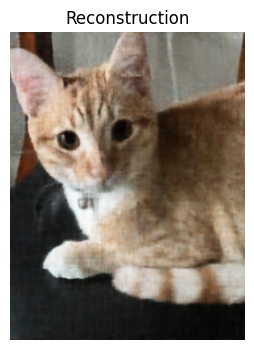

In [27]:

class PositionalEncoding(nn.Module):
    def __init__(self, L):
        super().__init__()
        self.L = L
        self.freq_bands = 2.0 ** torch.linspace(0, L - 1, L)

    def forward(self, x):
        out = [x]
        for freq in self.freq_bands:
            out.append(torch.sin(2 * np.pi * freq * x))
            out.append(torch.cos(2 * np.pi * freq * x))
        return torch.cat(out, dim=-1)

class MLP(nn.Module):
    def __init__(self, in_dim, width=256, out_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, out_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

class ImageDataset(Dataset):
    def __init__(self, image_path, num_samples=10_000):
        img = np.array(Image.open(image_path)) / 255.0
        self.H, self.W = img.shape[:2]
        self.img = torch.tensor(img, dtype=torch.float32)
        self.coords = self.create_coords()
        self.num_samples = num_samples

    def create_coords(self):
        y, x = torch.meshgrid(
            torch.linspace(0, 1, self.H), torch.linspace(0, 1, self.W), indexing="ij"
        )
        coords = torch.stack([x, y], dim=-1).reshape(-1, 2)  # (H*W, 2)
        return coords

    # def __len__(self):
    #     return int(np.ceil((self.H * self.W) / self.num_samples))

    # def __getitem__(self, idx):
    #     # Randomly sample num_samples pixels
    #     idxs = torch.randint(0, self.H * self.W, (self.num_samples,))
    #     coords = self.coords[idxs]                # (N, 2)
    #     rgbs = self.img.reshape(-1, 3)[idxs]      # (N, 3)
    #     return coords, rgbs

def compute_psnr(mse):
    return -10.0 * torch.log10(mse)

def train_model(image_path, L=10, hidden_dim=256, lr=1e-2, iterations=2000):
    dataset = ImageDataset(image_path, num_samples=10_000)

    pe = PositionalEncoding(L)
    in_dim = 2 + 4 * L
    model = MLP(in_dim, hidden_dim).to(device)
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    H, W = img.shape[:2]
    y, x = torch.meshgrid(
        torch.linspace(0, 1, H),
        torch.linspace(0, 1, W),
        indexing='ij'
    )
    all_coords = torch.stack([x, y], dim=-1).reshape(-1, 2).to(device)
    all_rgbs = torch.tensor(img / 255.0, dtype=torch.float32).reshape(-1, 3).to(device)

    N = all_coords.shape[0]
    batch_size = 10000

    loss_func = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    psnr_list = []

    for it in range(iterations):
        idxs = torch.randint(0, N, (batch_size,), device=device)

        coords = all_coords[idxs]
        rgbs   = all_rgbs[idxs]

        coords_enc = pe(coords)
        preds = model(coords_enc)

        loss = loss_func(preds, rgbs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        psnr = compute_psnr(loss)
        psnr_list.append(psnr.item())


        if it == iterations-1:
            with torch.no_grad():
                recon = reconstruct_image(model, pe, dataset)
                plt.figure(figsize=(4, 4))
                plt.title(f"Reconstruction")
                plt.imshow(recon)
                plt.axis("off")
                plt.show()

    return model, pe, dataset, it_list, psnr_list

def reconstruct_image(model, pe, dataset):
    coords = dataset.coords.to(device)
    coords_enc = pe(coords)
    with torch.no_grad():
        preds = model(coords_enc).detach().cpu().numpy().reshape(dataset.H, dataset.W, 3)
    return np.clip(preds, 0, 1)



if __name__ == "__main__":
    image_path = "/Users/ritikajoshi/Documents/Berkeley/CS/CS180/rjoshi07.github.io/4/peter.png"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model, pe, dataset, it_list, psnr_list = train_model(
        image_path, L=10, hidden_dim=64, lr=1e-2, iterations=2000
    )

    recon = reconstruct_image(model, pe, dataset)

    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    # plt.title("Ground Truth")
    # plt.imshow(dataset.img)
    # plt.axis("off")

    # plt.subplot(1, 2, 2)
    # plt.title("Reconstruction")
    # plt.imshow(recon)
    # plt.axis("off")
    # plt.show()

    # plt.figure(figsize=(6, 4))
    # plt.plot(range(2000), psnr_list)
    # plt.xlabel("Iteration")
    # plt.ylabel("Full-image PSNR (dB)")
    # plt.title("PSNR Curve During Training")
    # plt.grid(True)
    # plt.show()



2.1

In [30]:
data = np.load(f"lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images:
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering:
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float


In [38]:
data = np.load(f"nerf_dataset.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images:
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering:
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

In [31]:
def transform(T, x):
    ones = torch.ones_like(x[..., :1])
    x_h = torch.cat([x, ones], dim=-1)

    x_w_h = x_h @ T.transpose(-1, -2) 
    return x_w_h[..., :3]


In [32]:
def pixel_to_camera(K, uv, s=1.0):
    u, v = uv[..., 0], uv[..., 1]

    fx = K[0, 0]
    fy = K[1, 1]
    ox = K[0, 2]
    oy = K[1, 2]

    x_c = (u - ox) * (s / fx)
    y_c = (v - oy) * (s / fy)
    z_c = torch.full_like(x_c, s)

    return torch.stack([x_c, y_c, z_c], dim=-1)

def pixel_to_ray(K, c2w, uv):
    ray_o = c2w[:3, 3]

    while ray_o.ndim < uv.ndim:
        ray_o = ray_o.unsqueeze(0)

    X_c = pixel_to_camera(K, uv, s=1.0)

    X_w = transform(c2w, X_c)

    ray_d = X_w - ray_o
    ray_d = ray_d / torch.norm(ray_d, dim=-1, keepdim=True)

    return ray_o, ray_d


2.2 + 2.3

In [33]:
def build_all_rays(images, c2ws, K, device):
    H, W = images[0].shape[:2]
    u = torch.linspace(0, W-1, W, device=device) + 0.5
    v = torch.linspace(0, H-1, H, device=device) + 0.5
    v, u = torch.meshgrid(v, u, indexing='ij')
    uv = torch.stack([u, v], dim=-1)
    uv = uv.reshape(-1, 2)

    all_rays_o = []
    all_rays_d = []
    all_rgbs    = []

    for img, c2w in zip(images, c2ws):
        img = torch.tensor(img, dtype=torch.float32, device=device) / 255.0
        img = img.reshape(-1, 3)

        ray_o, ray_d = pixel_to_ray(K, c2w, uv)

        all_rays_o.append(ray_o)
        all_rays_d.append(ray_d)
        all_rgbs.append(img)

    return (
        torch.cat(all_rays_o, dim=0),
        torch.cat(all_rays_d, dim=0),
        torch.cat(all_rgbs, dim=0)
    )


In [34]:
class RaysData:
    def __init__(self, images, K, c2ws, device):
        self.device = device
        self.images_np = images
        self.N, self.H, self.W, _ = images.shape
        self.num_pixels = self.N * self.H * self.W

        # Preload colors ONCE
        pix = self.images_np.reshape(-1, 3)
        if pix.max() > 1:
            pix = pix / 255.0
        self.pixels = torch.tensor(pix, dtype=torch.float32, device=device)

        self.K = torch.tensor(K, dtype=torch.float32, device=device)
        self.c2ws = torch.tensor(c2ws, dtype=torch.float32, device=device)

        u = torch.arange(self.W, device=device)
        v = torch.arange(self.H, device=device)
        vv, uu = torch.meshgrid(v, u, indexing="ij")
        uv_centers = torch.stack([uu+0.5, vv+0.5], dim=-1).reshape(-1,2)
        uv_centers = uv_centers.unsqueeze(0).repeat(self.N,1,1).reshape(-1,2)

        self.rays_o, self.rays_d = self.compute_all_rays(uv_centers)
        self.rays_o = self.rays_o.to(device)
        self.rays_d = self.rays_d.to(device)

    def sample_rays(self, B):
        indices = torch.randint(0, self.num_pixels, (B,), device=self.device)
        return (
            self.rays_o[indices],
            self.rays_d[indices],
            self.pixels[indices]
        )

    def compute_all_rays(self, uv_centers):
        fx, fy = self.K[0, 0], self.K[1, 1]
        ox, oy = self.K[0, 2], self.K[1, 2]

        u = uv_centers[:, 0]
        v = uv_centers[:, 1]

        x = (u - ox) / fx
        y = (v - oy) / fy
        z = torch.ones_like(x)

        dirs_c = torch.stack([x, y, z], dim=-1)

        c2ws_expanded = self.c2ws.repeat_interleave(self.H * self.W, dim=0)
        R = c2ws_expanded[:, :3, :3]
        t = c2ws_expanded[:, :3, 3]

        dirs_w = torch.bmm(R, dirs_c[..., None]).squeeze(-1)
        dirs_w = dirs_w / torch.norm(dirs_w, dim=-1, keepdim=True)

        origins = t
        return origins, dirs_w


In [36]:
def sample_along_rays(rays_o, rays_d, n_samples=64, near=2.0, far=6.0, perturb=True):
    B = rays_o.shape[0]

    t_vals = torch.linspace(near, far, n_samples + 1, device=rays_o.device)
    mids  = (t_vals[:-1] + t_vals[1:]) * 0.5
    widths = (t_vals[1:] - t_vals[:-1])

    if perturb:
        t_samples = mids + (torch.rand(B, n_samples, device=rays_o.device)-0.5)*widths
    else:
        t_samples = mids.expand(B, n_samples)

    pts = rays_o[:,None,:] + rays_d[:,None,:] * t_samples[...,None]
    return pts


2.4

In [38]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_freqs):
        super().__init__()
        self.num_freqs = num_freqs
        self.freq_bands = 2.0 ** torch.linspace(0, num_freqs - 1, num_freqs)

    def forward(self, x):
        out = [x]

        for freq in self.freq_bands:
            out.append(torch.sin(freq * x))
            out.append(torch.cos(freq * x))

        return torch.cat(out, dim=-1)

class NeRF(nn.Module):
    def __init__(self,
                 Lx=10,
                 Ld=4,
                 hidden_dim=256):
        super().__init__()

        self.pe_x = PositionalEncoding(Lx)
        self.pe_d = PositionalEncoding(Ld)

        in_dim_x = 3 + 6 * Lx 
        in_dim_d = 3 + 6 * Ld

        self.layers_x = nn.ModuleList([
            nn.Linear(in_dim_x, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
        ])
        self.skip_layer = nn.Linear(in_dim_x + hidden_dim, hidden_dim)
        self.layers_post_skip = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
        ])
        self.density_head = nn.Linear(hidden_dim, 1)
        self.color_layer1 = nn.Linear(hidden_dim + in_dim_d, 128)
        self.color_layer2 = nn.Linear(128, 3)

    def forward(self, x, d):

        B, N, _ = x.shape

        x_flat = x.reshape(-1, 3)
        d_flat = d[:, None, :].repeat(1, N, 1).reshape(-1, 3)

        x_enc = self.pe_x(x_flat)
        d_enc = self.pe_d(d_flat)

        h = x_enc
        for layer in self.layers_x:
            h = F.relu(layer(h))

        h = torch.cat([h, x_enc], dim=-1)
        h = F.relu(self.skip_layer(h))

        for layer in self.layers_post_skip:
            h = F.relu(layer(h))

        sigma = F.relu(self.density_head(h))

        h_color = torch.cat([h, d_enc], dim=-1)

        h_color = F.relu(self.color_layer1(h_color))
        rgb = torch.sigmoid(self.color_layer2(h_color))

        sigma = sigma.reshape(B, N, 1)
        rgb = rgb.reshape(B, N, 3)

        return sigma, rgb


In [42]:
# Visualize Cameras, Rays and Samples
import viser, time
import numpy as np

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train, device="cpu")

# This will check that your uvs aren't flipped
uvs_start = 0
uvs_end = 40_000
sample_uvs = dataset.uvs[uvs_start:uvs_end] # These are integer coordinates of widths / heights (xy not yx) of all the pixels in an image
# uvs are array of xy coordinates, so we need to index into the 0th image tensor with [0, height, width], so we need to index with uv[:,1] and then uv[:,0]
assert np.all(images_train[0, sample_uvs[:,1], sample_uvs[:,0]] == dataset.pixels[uvs_start:uvs_end])

# # Uncoment this to display random rays from the first image
# indices = np.random.randint(low=0, high=40_000, size=100)

# # Uncomment this to display random rays from the top left corner of the image
# indices_x = np.random.randint(low=100, high=200, size=100)
# indices_y = np.random.randint(low=0, high=100, size=100)
# indices = indices_x + (indices_y * 200)

data = {"rays_o": dataset.rays_o[indices], "rays_d": dataset.rays_d[indices]}
points = sample_along_rays(data["rays_o"], data["rays_d"], random=True)
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
  server.add_camera_frustum(
    f"/cameras/{i}",
    fov=2 * np.arctan2(H / 2, K[0, 0]),
    aspect=W / H,
    scale=0.15,
    wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
    position=c2w[:3, 3],
    image=image
  )
for i, (o, d) in enumerate(zip(data["rays_o"], data["rays_d"])):
  positions = np.stack((o, o + d * 6.0))
  server.add_spline_catmull_rom(
      f"/rays/{i}", positions=positions,
  )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.03,
)

while True:
    time.sleep(0.1)  # Wait to allow visualization to run

AttributeError: 'RaysData' object has no attribute 'uvs'

2.5

In [ ]:

def volrend(sigmas, rgbs, step_size):
    alpha = 1.0 - torch.exp(-sigmas * step_size)
    cumsum = torch.cumsum(sigmas * step_size, dim=1)

    shifted = torch.cat(
        [torch.zeros_like(cumsum[:, :1, :]), cumsum[:, :-1, :]],
        dim=1
    )

    T = torch.exp(-1*shifted)

    rendered = torch.sum(T * alpha * rgbs, dim=1)

    return rendered


In [ ]:
torch.manual_seed(42)
sigmas = torch.rand((10, 64, 1))
rgbs = torch.rand((10, 64, 3))
step_size = (6.0 - 2.0) / 64
rendered_colors = volrend(sigmas, rgbs, step_size)

correct = torch.tensor([
    [0.5006, 0.3728, 0.4728],
    [0.4322, 0.3559, 0.4134],
    [0.4027, 0.4394, 0.4610],
    [0.4514, 0.3829, 0.4196],
    [0.4002, 0.4599, 0.4103],
    [0.4471, 0.4044, 0.4069],
    [0.4285, 0.4072, 0.3777],
    [0.4152, 0.4190, 0.4361],
    [0.4051, 0.3651, 0.3969],
    [0.3253, 0.3587, 0.4215]
])
assert torch.allclose(rendered_colors, correct, rtol=1e-4, atol=1e-4)
print("✅ volrend matches reference output!")


✅ volrend matches reference output!


2.5

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

H, W = images_train.shape[1:3]

K = np.array([
    [focal, 0,      W / 2.0],
    [0,      focal, H / 2.0],
    [0,      0,     1.0]
], dtype=np.float32)

Using device: cuda


In [ ]:
def get_rays(H, W, K, c2w, device=device):
    K = torch.tensor(K, dtype=torch.float32, device=device)
    c2w = torch.tensor(c2w, dtype=torch.float32, device=device)

    i = torch.arange(W, device=device)
    j = torch.arange(H, device=device)
    jj, ii = torch.meshgrid(j, i, indexing="ij")

    # center pixels
    ii = ii + 0.5
    jj = jj + 0.5

    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    dirs = torch.stack(
        [(ii - cx) / fx,
         (jj - cy) / fy,
         torch.ones_like(ii)],
        dim=-1
    )

    dirs = dirs.reshape(-1, 3)
    R = c2w[:3, :3]
    t = c2w[:3, 3]

    rays_d = (dirs @ R.T) / torch.norm(rays_d, dim=-1, keepdim=True)
    rays_o = t.expand_as(rays_d) 

    return rays_o, rays_d


In [32]:
train_dataset = NeRFDataset(images_train, c2ws_train, K)
val_dataset   = NeRFDataset(images_val,   c2ws_val,   K)


In [ ]:
torch.cuda.empty_cache()
def mse2psnr(mse):
    return -10.0 * torch.log10(mse)


def render_image(model, c2w, K, H, W, device, n_samples=64, near=2.0, far=6.0, chunk=4096):
    rays_o, rays_d = get_rays(H, W, K, c2w, device=device)
    step_size = (far - near) / n_samples

    all_colors = []
    model.eval()
    with torch.no_grad():
        for i in range(0, rays_o.shape[0], chunk):
            ro = rays_o[i:i+chunk]
            rd = rays_d[i:i+chunk]
            pts = sample_along_rays(ro, rd, n_samples, near, far, perturb=False)
            sigmas, rgbs = model(pts, rd)
            cols = volrend(sigmas, rgbs, step_size)
            all_colors.append(cols.cpu())

    all_colors = torch.cat(all_colors, dim=0).reshape(H, W, 3).clamp(0, 1)
    return all_colors

def validate_psnr(model, images_val, K, c2ws_val, device,
                  n_images=6, n_samples=64, near=2.0, far=6.0):
    H, W = images_val.shape[1:3]
    psnrs = []

    for i in range(n_images):
        gt = torch.tensor(images_val[i], device=device, dtype=torch.float32)

        pred = render_image(
            model, c2ws_val[i], K, H, W, device,
            n_samples=n_samples, near=near, far=far
        )

        pred = pred.to(device)

        mse = torch.mean((pred - gt)**2)
        psnr = mse2psnr(mse)
        psnrs.append(psnr.item())

    return np.mean(psnrs)

n_iters = 1600
batch_rays = 10_000
n_samples = 64
near, far = 2.0, 6.0
step_size = (far - near) / n_samples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_dataset = RaysData(images_train, K, c2ws_train, device=device)
val_dataset   = RaysData(images_val,   K, c2ws_val,   device=device)

model = NeRF().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

val_iters = []
train_snaps = []
train_snap_iters = []
train_psnrs = []
val_psnrs = []
train_losses = []


for it in range(1, n_iters+1):
  torch.cuda.empty_cache()

  model.train()

  rays_o, rays_d, rgb_gt = train_dataset.sample_rays(batch_rays)

  pts = sample_along_rays(rays_o, rays_d,
                              n_samples, near, far, perturb=True)

  sigmas, rgbs = model(pts, rays_d)
  rgb_pred = volrend(sigmas, rgbs, step_size)

  loss = nn.functional.mse_loss(rgb_pred, rgb_gt)
  train_losses.append(loss.item())

  train_psnrs.append(mse2psnr(loss).item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if it % 200 == 0 or it == n_iters:
      val_psnr = validate_psnr(model, images_val, K, c2ws_val, device, n_images=len(images_val))
      val_psnrs.append((it, val_psnr))
  if it % 400 == 0:
    with torch.no_grad():
        snap_img = render_image(model, c2ws_val[0], K, H, W, device)
        train_snaps.append(snap_img)
        train_snap_iters.append(it)


Using device: cuda
[100] loss=0.25313, train PSNR=5.97
[200] loss=0.25664, train PSNR=5.91
  [val] PSNR over 5 val images = 5.81 dB
[300] loss=0.25471, train PSNR=5.94
[400] loss=0.25912, train PSNR=5.86
  [val] PSNR over 5 val images = 5.81 dB
  [snapshot] Rendered snapshot at iter 400
[500] loss=0.25723, train PSNR=5.90
[600] loss=0.25806, train PSNR=5.88
  [val] PSNR over 5 val images = 5.81 dB
[700] loss=0.25861, train PSNR=5.87
[800] loss=0.25851, train PSNR=5.88
  [val] PSNR over 5 val images = 5.81 dB
  [snapshot] Rendered snapshot at iter 800
[900] loss=0.25590, train PSNR=5.92
[1000] loss=0.25848, train PSNR=5.88
  [val] PSNR over 5 val images = 5.81 dB
[1100] loss=0.25971, train PSNR=5.86
[1200] loss=0.25847, train PSNR=5.88
  [val] PSNR over 5 val images = 5.81 dB
  [snapshot] Rendered snapshot at iter 1200
[1300] loss=0.25682, train PSNR=5.90
[1400] loss=0.25971, train PSNR=5.86
  [val] PSNR over 5 val images = 5.81 dB
[1500] loss=0.25990, train PSNR=5.85
[1600] loss=0.2592

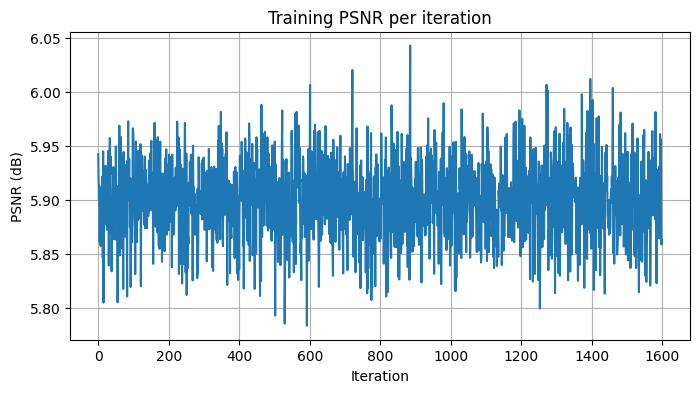

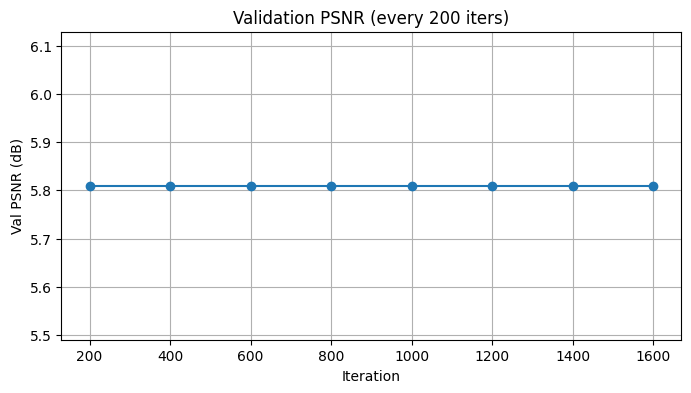

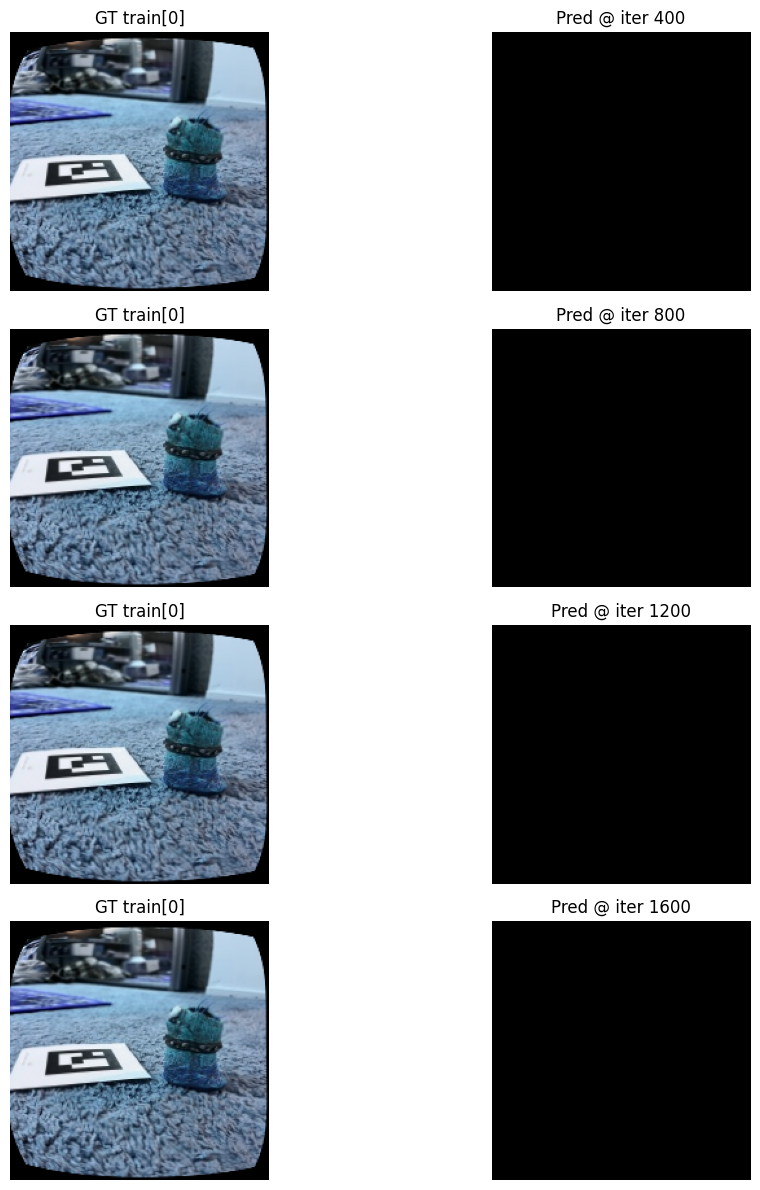

In [ ]:

plt.figure(figsize=(8,4))
plt.plot(train_psnrs)
plt.title("Training PSNR per iteration")
plt.xlabel("Iteration")
plt.ylabel("PSNR (dB)")
plt.grid()
plt.show()

if len(val_psnrs) > 0:
    its, ps = zip(*val_psnrs)
    plt.figure(figsize=(8,4))
    plt.plot(its, ps, marker='o')
    plt.title("Validation PSNR (every 200 iters)")
    plt.xlabel("Iteration")
    plt.ylabel("Val PSNR (dB)")
    plt.grid()
    plt.show()


n_show = min(len(train_snaps), 4)

plt.figure(figsize=(12, 3 * n_show))
for i in range(n_show):
    iter_i = train_snap_iters[i]
    pred = train_snaps[i]
    gt = images_train[0]

    plt.subplot(n_show, 2, 2*i + 1)
    plt.imshow(gt)
    plt.axis("off")
    plt.title(f"GT train[0]")

    plt.subplot(n_show, 2, 2*i + 2)
    plt.imshow(pred)
    plt.axis("off")
    plt.title(f"Pred @ iter {iter_i}")
plt.tight_layout()
plt.show()


In [ ]:

frames = []
for i, c2w in enumerate(c2ws_test):
    img = render_image(
        model, c2w, K, H, W, device,
        n_samples=n_samples, near=near, far=far
    )
    frame = (img.cpu().numpy() * 255).astype(np.uint8)
    frames.append(frame)

imageio.mimsave("lego_spherical.gif", frames, fps=15)


Rendering spherical novel-view video...


NameError: name 'c2ws_test' is not defined